# Electricity Customer에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,RMSE,MAE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

## 1. 모델 구성하기
* 시간단위의 데이터로써 24x30 =720 즉 30일을 바라봄

In [3]:
data = pd.read_csv('../../../GeneralData/ElectricityCustomer.csv')
sequence_length = 720
pred_len = 360

In [4]:
data = data.drop(columns='Unnamed: 0')

In [5]:
data = data[['customer8']]

In [6]:
data

,customer8
0,989.898990
1,1000.000000
2,1006.734007
3,831.649832
4,764.309764
...,...
8756,1262.626263
8757,1077.441077
8758,1006.734007
8759,1003.367003


<AxesSubplot: >

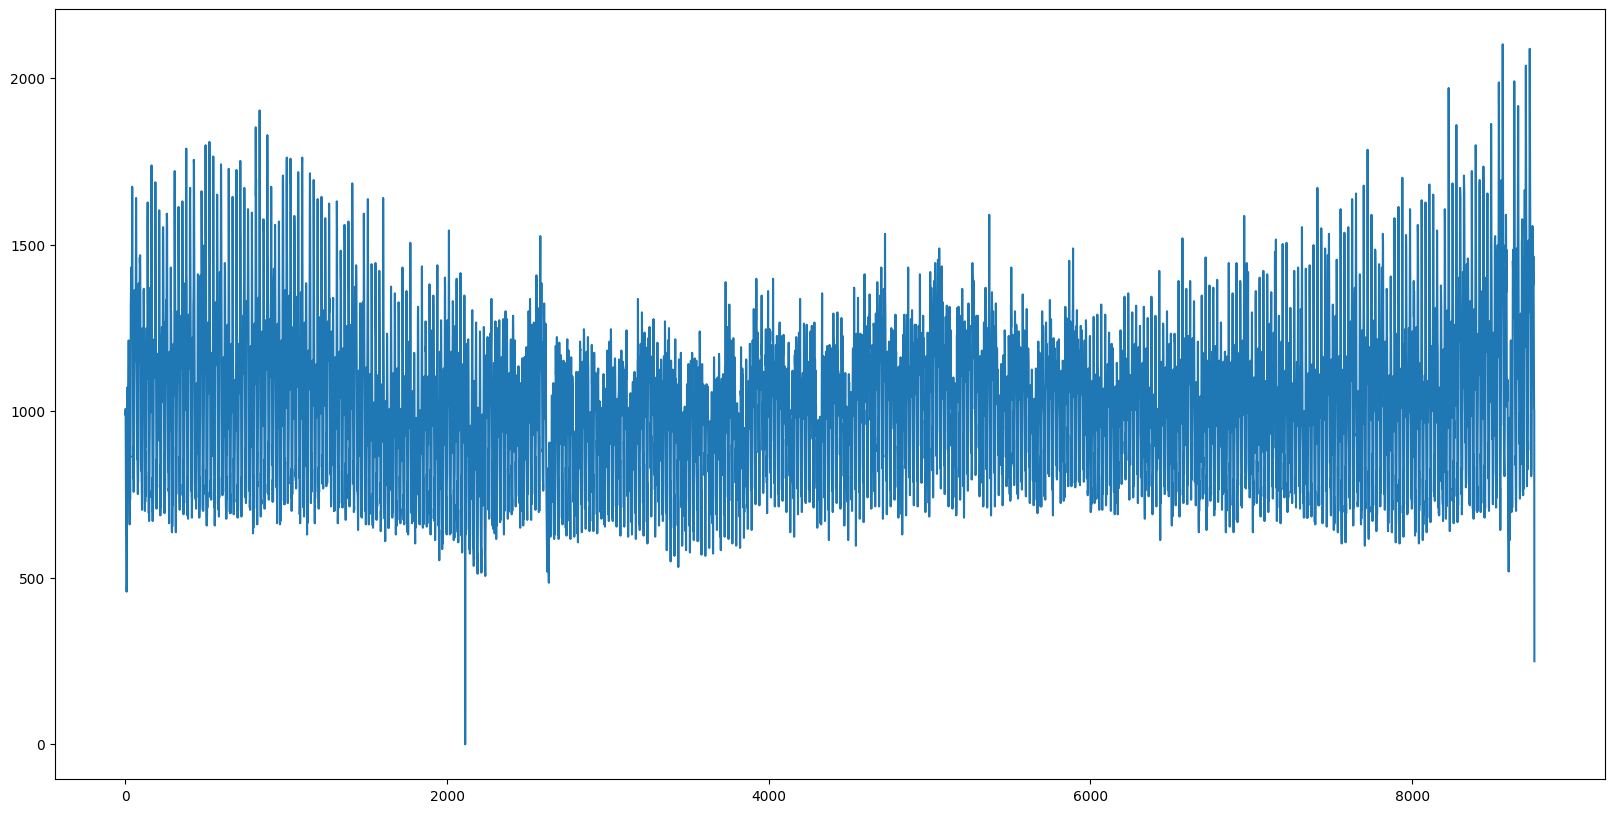

In [7]:
plt.figure(figsize=(20,10))
data['customer8'].plot()

In [8]:
from torch import FloatTensor as FloatTensor

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length-pred_len+1):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)
        
    return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)

In [10]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [11]:
seed = 42

In [12]:
device = torch.device("cuda:0")

In [13]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 360 # 1440
        self.train_index = train_index
        
        self.first_layer = nn.Linear(self.seq_len,self.seq_len//2)
        self.second_layer = nn.Linear(self.seq_len//2,self.pred_len)
#         self.third_layer = nn.Linear(self.seq_len//4,self.pred_len)
        
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.seq_len//2,self.seq_len]))
        self.second_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//2]))
#         self.third_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//4]))
    def forward(self,x):
        first_result = self.first_layer(x[:,self.train_index]) 
        final_result = self.second_layer(first_result)
#         final_result = self.third_layer(second_result)
        return final_result

# 3. Train-Validation set으로 쪼개기

In [14]:
data

,customer8
0,989.898990
1,1000.000000
2,1006.734007
3,831.649832
4,764.309764
...,...
8756,1262.626263
8757,1077.441077
8758,1006.734007
8759,1003.367003


* 8761개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 8761 중 0.2의 비율인 1752개는 validation set
* 8761개 중 0.8의 비율인 7009개는 train set

In [15]:
val_num = 1752

In [16]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_852483/3825588569.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)


In [17]:
train.tail(11)

,customer8
6830,757.575758
6831,804.713805
6832,841.750842
6833,882.154882
6834,956.228956
6835,1127.946128
6836,1178.451178
6837,1161.616162
6838,983.164983
6839,872.053872


In [18]:
y_train.size()

torch.Size([5762, 360])

In [19]:
y_train[-1,-10:]

tensor([ 804.7138,  841.7509,  882.1549,  956.2289, 1127.9462, 1178.4512,
        1161.6162,  983.1650,  872.0539,  757.5757], device='cuda:0')

In [20]:
next(iter(validation))[0].size()

torch.Size([64, 720])

In [21]:
x_train.size()

torch.Size([5762, 720])

In [22]:
x_val.size()

torch.Size([673, 720])

In [23]:
y_val.size()

torch.Size([673, 360])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [24]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs = 100
n= len(training)

### 기본 모델 training

In [25]:
import copy

In [26]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 5204631.432
changed
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 3752174.161
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [41]/[100] running accumulative loss across all batches: 2477426.423
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [61]/[100] running accumulative loss across all batches: 1958718.601
changed
changed
changed
changed
changed
changed
changed
Epoch [81]/[100] running accumulative loss across all batches: 1860906.853
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed


## size를 (-1,1)로 view해도 똑같은 결과가 나옴을 알 수 있다.

In [27]:
output = outputs
label = labels

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
mean_squared_error(outputs.cpu().detach().numpy(),labels.cpu().detach().numpy())

11604.958

In [30]:
mean_squared_error(output.squeeze(1).cpu().detach().numpy(),label.squeeze(1).cpu().detach().numpy())

11604.958

### validation set에 대해서 attribution 구하기

In [31]:
n = len(validation)
n

11

### attribution 뽑아내는데 대략 20분 소요

In [32]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((pred_len,sequence_length)).to(device)
for val in validation: # validation dataloader
    temp_n = val[0].size(0)
    for i in range(pred_len): # target 0에 대한 영향부터 pred_len에 대한 영향까지 모두 더해서 평균적인 영향도를 측정
        temp = nt_ig.attribute(val[0],target=(i,)).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음 각 feature의 영향도를 계산 위해
        nt_ig_attr_score[i] = nt_ig_attr_score[i]+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.mean(axis = 0)
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [33]:
print(temp.size()) # sum하기전에 형태

torch.Size([720])


In [34]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

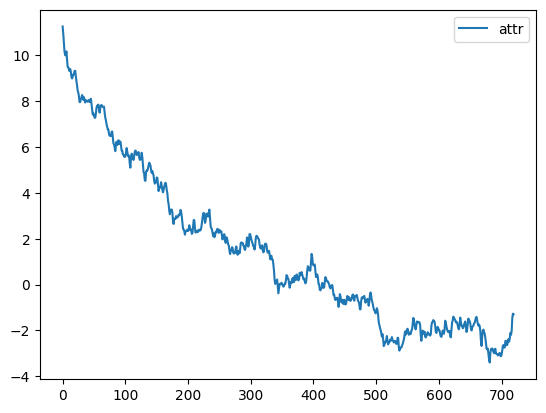

In [35]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

* 표준화는 데이터가 정규분포를 따른다고 가정해야지 1sigma와 -1sigma에 68%정도의 데이터가 모여있음
* 데이터를 z-score로 변환(즉, 데이터를 표준화 또는 정규화)한다고 해서 데이터가 정규분포가 되는 것은 아니다. 단지 비교를 목적으로 데이터를 표준정규분포와 같은 척도로 만드는 것 뿐이다.
* 결과적으로 원래 정규분포의 형태였던 분포를 공통척도(평균은 0 표준편차는 1)로 바꾸는 것

https://hleecaster.com/ml-normalization-concept/

## 아무런 Scaling을 하지 않았을때

<AxesSubplot: >

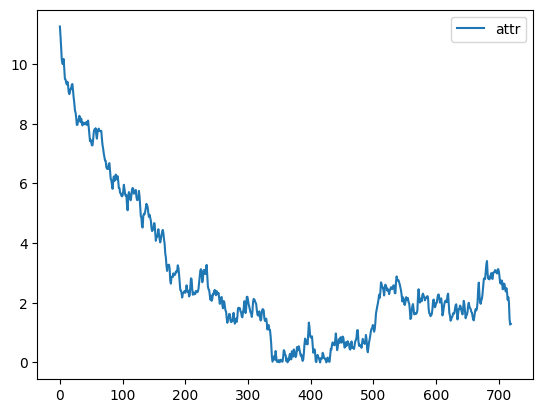

In [36]:
attr_df = attr_df.abs()
attr_df.plot()

## Outlier정의 계수(1.5)도 파라미터로 정할수 있도록

In [37]:
IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
outlier_max = attr_df.quantile(0.75)+IQR
outlier_min = attr_df.quantile(0.25)-IQR
candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
candidate_attr = candidate_attr.dropna()
candidate_attr

,attr
96,5.683075
97,5.669786
98,5.593102
99,5.566773
100,5.597012
...,...
715,2.189604
716,2.020601
717,1.462020
718,1.269781


In [38]:
outlier_max

attr    5.7979
dtype: float64

In [39]:
outlier_min

attr   -1.275739
dtype: float64

<AxesSubplot: >

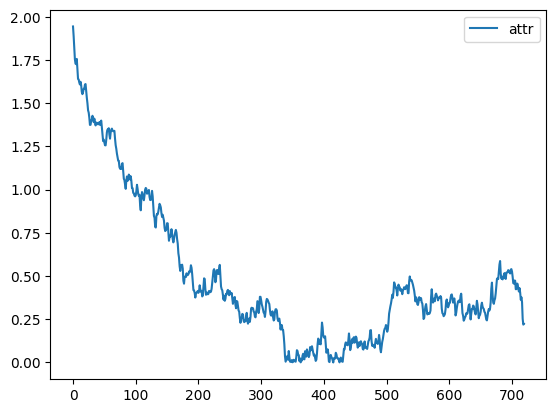

In [40]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(candidate_attr.values)
m_attr_df = scaler.transform(attr_df.values)
m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
m_attr_df.plot()

In [41]:
m_attr_df.describe()

,attr
count,720.000000
mean,0.487415
std,0.416660
min,0.000000
25%,0.237616
50%,0.370237
75%,0.542867
max,1.943947


## 0과 1사이의 분포 확인하기

In [42]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna()

,attr
96,0.980924
97,0.978630
98,0.965394
99,0.960849
100,0.966068
...,...
715,0.377904
716,0.348732
717,0.252313
718,0.219130


* outlier를 제외하면 들어와있음을 확인할 수 있다.

<AxesSubplot: >

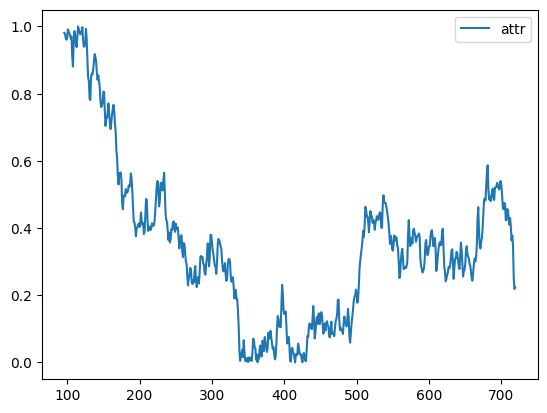

In [43]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna().plot()

### MinMaxScaler와 비교

<AxesSubplot: >

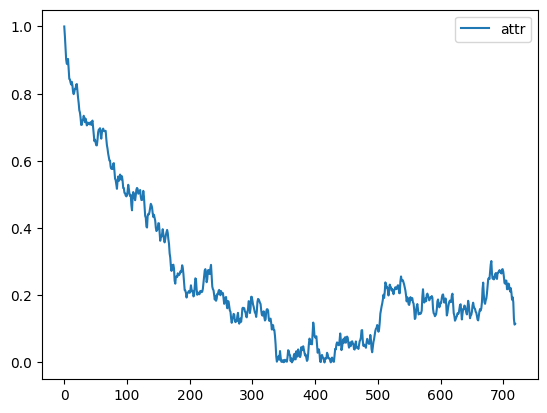

In [44]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
attr_df.plot()

#### train_index구하기

In [45]:
index_list = []

for hyper_para in np.arange(0.00,1.01,0.01):
    append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

101

In [46]:
len_list=[]
for i in range(101):
    len_list.append(len(index_list[i]))


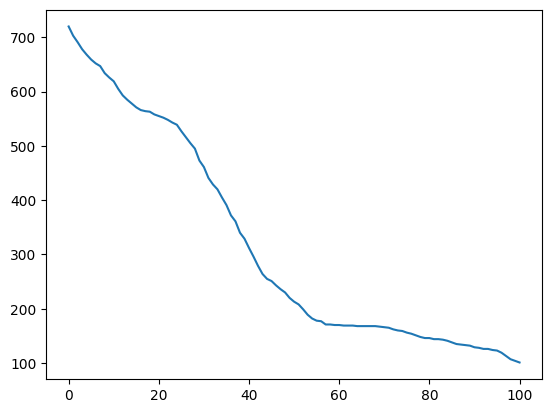

In [47]:
plt.plot(np.arange(101),len_list) # 포함되는 time_index의 갯수

In [48]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
num_epochs = 100
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:1651381.0310782967
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:1679681.640625
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
25번째 모델 Training 완료 마지막 Epoch loss:2157673.6499828296
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
26번째 모델 Training 완료 마지막 Epoch loss:2200532.1192479394
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
27번째 모델 Training 완료 마지막 Epoch loss:2236558.8910113326
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
change

changed
changed
66번째 모델 Training 완료 마지막 Epoch loss:4006924.2487980765
changed
changed
67번째 모델 Training 완료 마지막 Epoch loss:4006924.2487980765
changed
changed
68번째 모델 Training 완료 마지막 Epoch loss:4006924.2487980765
changed
changed
69번째 모델 Training 완료 마지막 Epoch loss:4004531.97759272
changed
changed
70번째 모델 Training 완료 마지막 Epoch loss:4003952.2364354394
changed
changed
71번째 모델 Training 완료 마지막 Epoch loss:4001665.547733517
changed
changed
72번째 모델 Training 완료 마지막 Epoch loss:3998377.618475275
changed
changed
73번째 모델 Training 완료 마지막 Epoch loss:3995541.2431318685
changed
changed
74번째 모델 Training 완료 마지막 Epoch loss:3993356.0439560437
changed
changed
75번째 모델 Training 완료 마지막 Epoch loss:3990542.6854395606
changed
changed
76번째 모델 Training 완료 마지막 Epoch loss:3988637.5257554944
changed
changed
77번째 모델 Training 완료 마지막 Epoch loss:3984650.133070055
changed
changed
78번째 모델 Training 완료 마지막 Epoch loss:3982623.4460851653
changed
changed
79번째 모델 Training 완료 마지막 Epoch loss:3980241.891311813
changed
changed
80번째 모델 Tr

In [49]:
val_y # 다음 예측 타겟값

tensor([[1053.8721, 1420.8754, 1606.0605,  ..., 1343.4343, 1377.1044,
         1329.9663],
        [1420.8754, 1606.0605, 1565.6566,  ..., 1377.1044, 1329.9663,
         1447.8114],
        [1606.0605, 1565.6566, 1393.9395,  ..., 1329.9663, 1447.8114,
         1875.4209],
        ...,
        [1087.5421,  932.6599,  754.2087,  ..., 1175.0842, 1013.4680,
         1070.7070],
        [ 932.6599,  754.2087,  639.7307,  ..., 1013.4680, 1070.7070,
         1033.6700],
        [ 754.2087,  639.7307,  821.5488,  ..., 1070.7070, 1033.6700,
         1030.3030]], device='cuda:0')

In [50]:
val_x # 예측 하는 값

tensor([[1242.4242, 1468.0134, 1531.9866,  ...,  956.2289,  848.4849,
          818.1818],
        [1468.0134, 1531.9866, 1397.3064,  ...,  848.4849,  818.1818,
         1053.8721],
        [1531.9866, 1397.3064, 1215.4882,  ...,  818.1818, 1053.8721,
         1420.8754],
        ...,
        [ 902.3569,  777.7778,  643.0977,  ..., 1693.6027, 1478.1145,
         1323.2323],
        [ 777.7778,  643.0977,  744.1077,  ..., 1478.1145, 1323.2323,
         1087.5421],
        [ 643.0977,  744.1077,  744.1077,  ..., 1323.2323, 1087.5421,
          932.6599]], device='cuda:0')

In [51]:
result/68

1410.6021369485295

In [52]:
val_x.size()

torch.Size([33, 720])

            out
0  20443.021484


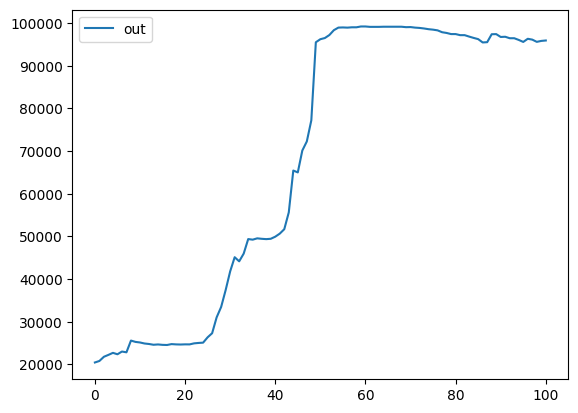

In [53]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [54]:
out_df 

,out
0,20443.021484
1,20795.001953
2,21780.994141
3,22223.443359
4,22699.632812
...,...
96,96318.804688
97,96122.773438
98,95601.132812
99,95820.937500


          out
0  106.145531


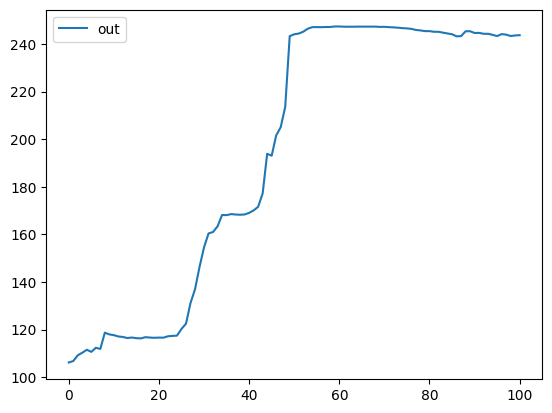

In [55]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [56]:
out_df 

,out
0,106.145531
1,106.748871
2,109.170364
3,110.245758
4,111.481430
...,...
96,244.185608
97,243.974869
98,243.392181
99,243.628723


        out
0  9.815173


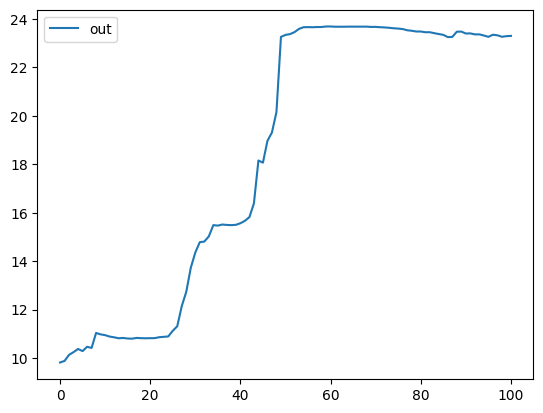

In [57]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [58]:
out_df 

,out
0,9.815173
1,9.878466
2,10.130191
3,10.242098
4,10.373630
...,...
96,23.352633
97,23.330353
98,23.268776
99,23.293909


          out
0  142.979095


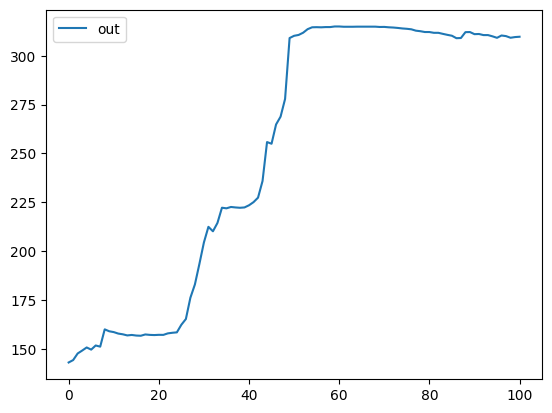

In [59]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [60]:
out_df 

,out
0,142.979095
1,144.204727
2,147.583862
3,149.075287
4,150.663986
...,...
96,310.352722
97,310.036743
98,309.194336
99,309.549561


In [61]:
attr_df.describe()

,attr
count,720.000000
mean,0.250735
std,0.214337
min,0.000000
25%,0.122234
50%,0.190456
75%,0.279260
max,1.000000
